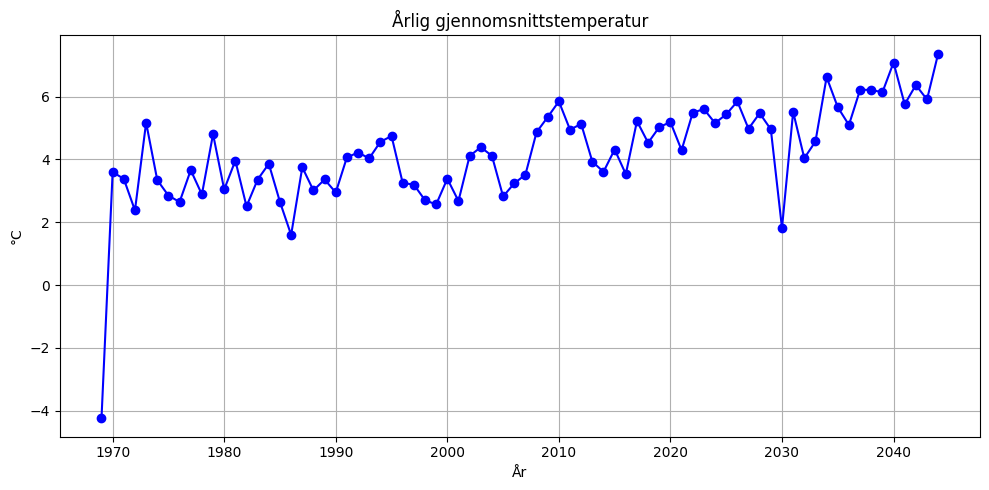

C:\Users\Even\AppData\Local\Temp\ipykernel_5084\4009221950.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="coolwarm")


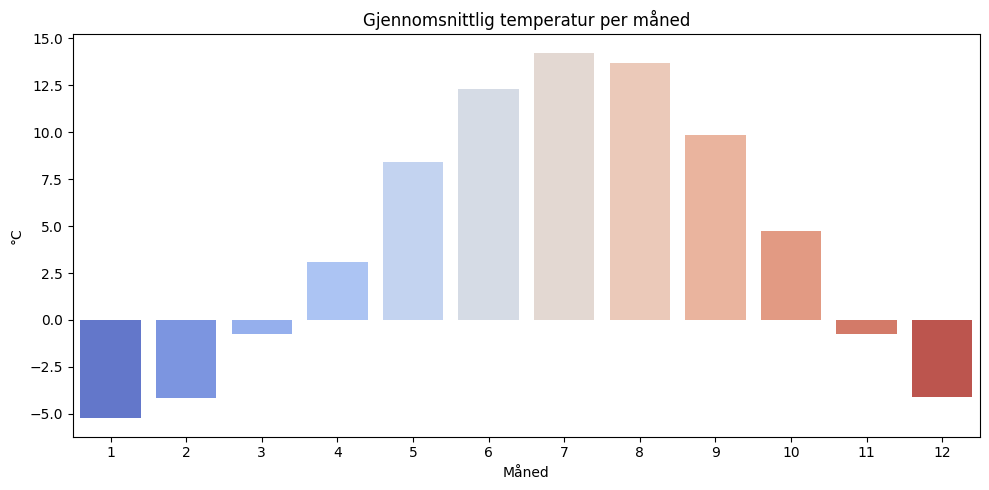

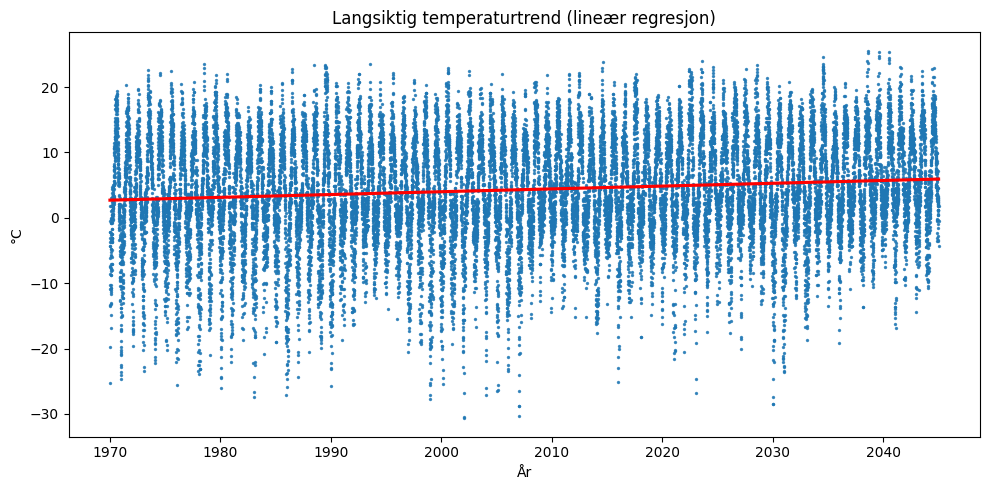

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry

# === Hent ekte temperaturdata fra Open-Meteo API ===
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 63.43,  # Trondheim f.eks.
    "longitude": 10.39,
    "start_date": "1950-01-01",
    "end_date": "2024-12-31",
    "daily": "temperature_2m_mean",
    "timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# === Konverter data til DataFrame ===
daily = response.Daily()
temps = daily.Variables(0).ValuesAsNumpy()
dates = pd.date_range(start=pd.to_datetime(daily.Time(), utc=True), periods=len(temps), freq="D")

df = pd.DataFrame({
    "date": dates,
    "temperature_2m": temps
})
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# === 1. Linjediagram: Årlig gjennomsnittstemperatur ===
plt.figure(figsize=(10, 5))
yearly_avg = df.groupby("year")["temperature_2m"].mean()
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linestyle='-', color='blue')
plt.title("Årlig gjennomsnittstemperatur")
plt.xlabel("År")
plt.ylabel("°C")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Søylediagram: Gjennomsnitt per måned over alle år ===
plt.figure(figsize=(10, 5))
monthly_avg = df.groupby("month")["temperature_2m"].mean()
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="coolwarm")
plt.title("Gjennomsnittlig temperatur per måned")
plt.xlabel("Måned")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

# === 3. Scatterplot med regresjonslinje: Temperaturtrend over tid ===
df["day_of_year"] = df["date"].dt.dayofyear
df["year_frac"] = df["year"] + df["day_of_year"] / 365

plt.figure(figsize=(10, 5))
sns.regplot(x="year_frac", y="temperature_2m", data=df, scatter_kws={'s': 2}, line_kws={"color": "red"})
plt.title("Langsiktig temperaturtrend (lineær regresjon)")
plt.xlabel("År")
plt.ylabel("°C")
plt.tight_layout()
plt.show()
